In [1]:
import os
import pathlib
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageOps
from IPython.display import display
from sklearn.utils import shuffle
import warnings
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


- Let's load in an arbitrary image:

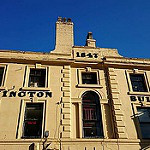

In [2]:
src_img = Image.open('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_train/seg_train/buildings/7570.jpg')
display(src_img)

- Here's the shape (width, height, color channels):

In [3]:
np.array(src_img).shape

(150, 150, 3)

- If flattened, it would result in this many features:

In [4]:
150 * 150 * 3

67500

- We can reduce the number by a factor of 3 by grayscaling the image
- We still know it's a cat, no matter if we lose the color info:

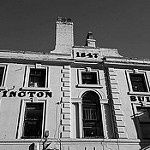

In [5]:
gray_img = ImageOps.grayscale(src_img)
display(gray_img)

In [6]:
np.array(gray_img).shape

(150, 150)

In [7]:
150 * 150

22500

- It's still a lot, so let's resize the image to something smaller
- Let's say 96x96:

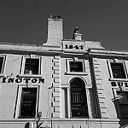

In [8]:
gray_resized_img = gray_img.resize(size=(128, 128))
display(gray_resized_img)

In [9]:
np.array(gray_resized_img).shape

(128, 128)

- Much less features:

In [10]:
128 * 128

16384

- This is how you can flatten the image and store it as an array:

In [11]:
np.ravel(gray_resized_img)

array([ 51,  51,  51, ..., 181, 192, 186], dtype=uint8)

- The values aren't in an ideal range (0-255)
- Neural network model prefers 0-1 range
- Let's transform it:

In [12]:
img_final = np.ravel(gray_resized_img) / 255.0

In [13]:
img_final

array([0.2       , 0.2       , 0.2       , ..., 0.70980392, 0.75294118,
       0.72941176])

- Finally, let's implement all of this in a single function:

In [14]:
def process_image(img_path: str) -> np.array:
    img = Image.open(img_path)
    img = ImageOps.grayscale(img)
    img = img.resize(size=(128, 128))
    img = np.ravel(img) / 255.0
    return img

- And let's test it:

In [15]:
tst_img = process_image(img_path='/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_train/seg_train/buildings/7570.jpg')

In [16]:
tst_img

array([0.2       , 0.2       , 0.2       , ..., 0.70980392, 0.75294118,
       0.72941176])

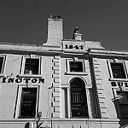

In [17]:
Image.fromarray(np.uint8(tst_img * 255).reshape((128, 128)))

- It works as expected, so let's apply the same logic to the entire dataset next.

<br>

## Process the entire dataset

- Let's declare a function that will process all images in a given folder
- The function returns processed images as a Pandas DataFrame
- We'll add an additional column just so we know the class:

In [18]:
def process_folder(folder: pathlib.PosixPath) -> pd.DataFrame:
    # We'll store the images here
    processed = []
    
    # For every image in the directory
    for img in folder.iterdir():
        # Ensure JPG
        if img.suffix == '.jpg':
            # Two images failed for whatever reason, so let's just ignore them
            try:
                processed.append(process_image(img_path=str(img)))
            except Exception as _:
                continue
           
    # Convert to pd.DataFrame
    processed = pd.DataFrame(processed)
    # Add a class column - dog or a cat
    processed['class'] = folder.parts[-1]
    
    return processed

- And now let's build ourselves training, validation, and test sets
- We'll start with the training set
    - Process both cat and dog images
    - Concatenate the two datasets
    - Save them in a pickle format, just so you don't have to go through the entire process again

In [19]:
%%time

train_build = process_folder(folder=pathlib.Path.cwd().joinpath('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_train/seg_train/buildings'))
train_forest = process_folder(folder=pathlib.Path.cwd().joinpath('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_train/seg_train/forest'))

train_set = pd.concat([train_build, train_forest], axis=0)

with open('train_set.pkl', 'wb') as f:
    pickle.dump(train_set, f)

CPU times: user 30.8 s, sys: 3.8 s, total: 34.6 s
Wall time: 1min 11s


In [20]:
train_set.shape

(3760, 16385)

- Now for the test set:

In [21]:
%%time

test_build = process_folder(folder=pathlib.Path.cwd().joinpath('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_test/seg_test/buildings'))
test_forest = process_folder(folder=pathlib.Path.cwd().joinpath('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_test/seg_test/forest'))

test_set = pd.concat([test_build, test_forest], axis=0)

with open('test_set.pkl', 'wb') as f:
    pickle.dump(test_set, f)

CPU times: user 4.59 s, sys: 272 ms, total: 4.86 s
Wall time: 8.53 s


In [22]:
test_set.shape

(538, 16385)

- And finally for the validation set:

In [23]:
%%time

valid_build = process_folder(folder=pathlib.Path.cwd().joinpath('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_valid/seg_valid/buildings'))
valid_forest = process_folder(folder=pathlib.Path.cwd().joinpath('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_valid/seg_valid/forest'))

valid_set = pd.concat([valid_build, valid_forest], axis=0)

with open('valid_set.pkl', 'wb') as f:
    pickle.dump(valid_set, f)

CPU times: user 9.45 s, sys: 921 ms, total: 10.4 s
Wall time: 19.2 s


In [24]:
valid_set.shape

(1075, 16385)

<br>

## Additional processing
- Datasets now contain images of cats first, followed by images of dogs
- We want to shuffle those datasets, so a neural network  goes through the images in a random order:

In [25]:
train_set = shuffle(train_set).reset_index(drop=True)
test_set = shuffle(train_set).reset_index(drop=True)
valid_set = shuffle(valid_set).reset_index(drop=True)

In [26]:
train_set.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16345,16346,16347,16348,16349,16350,16351,16352,16353,16354,16355,16356,16357,16358,16359,16360,16361,16362,16363,16364,16365,16366,16367,16368,16369,16370,16371,16372,16373,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383,class
0,0.427451,0.427451,0.423529,0.423529,0.423529,0.419608,0.419608,0.427451,0.419608,0.419608,0.423529,0.427451,0.427451,0.423529,0.431373,0.435294,0.435294,0.439216,0.450980,0.454902,0.447059,0.458824,0.474510,0.474510,0.462745,0.458824,0.466667,0.466667,0.482353,0.501961,0.509804,0.525490,0.537255,0.533333,0.513725,0.501961,0.501961,0.494118,0.454902,0.427451,...,0.066667,0.074510,0.078431,0.094118,0.090196,0.090196,0.094118,0.090196,0.070588,0.058824,0.082353,0.066667,0.074510,0.078431,0.086275,0.066667,0.074510,0.070588,0.078431,0.094118,0.062745,0.094118,0.090196,0.086275,0.070588,0.070588,0.101961,0.078431,0.090196,0.078431,0.066667,0.078431,0.121569,0.078431,0.094118,0.101961,0.101961,0.101961,0.133333,buildings
1,0.592157,0.600000,0.627451,0.596078,0.368627,0.309804,0.223529,0.505882,0.635294,0.788235,0.913725,0.737255,0.682353,0.752941,0.733333,0.733333,0.733333,0.733333,0.733333,0.733333,0.733333,0.733333,0.737255,0.737255,0.737255,0.737255,0.737255,0.737255,0.737255,0.737255,0.737255,0.737255,0.737255,0.737255,0.737255,0.741176,0.741176,0.745098,0.737255,0.733333,...,0.349020,0.000000,0.086275,0.227451,0.094118,0.031373,0.000000,0.211765,0.203922,0.337255,0.152941,0.047059,0.160784,0.098039,0.007843,0.007843,0.105882,0.164706,0.035294,0.047059,0.094118,0.125490,0.117647,0.125490,0.137255,0.152941,0.192157,0.172549,0.149020,0.117647,0.137255,0.168627,0.329412,0.431373,0.470588,0.439216,0.407843,0.380392,0.356863,buildings
2,0.133333,0.113725,0.125490,0.133333,0.149020,0.176471,0.231373,0.164706,0.145098,0.129412,0.105882,0.129412,0.196078,0.329412,0.286275,0.094118,0.317647,0.909804,0.533333,0.607843,0.901961,0.898039,0.894118,0.898039,0.529412,0.545098,0.760784,0.517647,0.270588,0.250980,0.223529,0.203922,0.254902,0.254902,0.266667,0.282353,0.298039,0.419608,0.415686,0.278431,...,0.423529,0.423529,0.400000,0.458824,0.427451,0.435294,0.443137,0.384314,0.407843,0.396078,0.392157,0.407843,0.384314,0.349020,0.388235,0.458824,0.439216,0.403922,0.419608,0.415686,0.356863,0.427451,0.403922,0.392157,0.384314,0.372549,0.364706,0.356863,0.392157,0.403922,0.380392,0.403922,0.380392,0.407843,0.392157,0.364706,0.337255,0.368627,0.321569,forest
3,0.074510,0.301961,0.200000,0.098039,0.145098,0.145098,0.231373,0.372549,0.094118,0.180392,0.105882,0.058824,0.086275,0.149020,0.133333,0.239216,0.223529,0.156863,0.207843,0.235294,0.262745,0.392157,0.196078,0.349020,0.317647,0.121569,0.176471,0.196078,0.294118,0.403922,0.156863,0.164706,0.250980,0.247059,0.223529,0.376471,0.349020,0.388235,0.388235,0.317647,...,0.137255,0.141176,0.156863,0.074510,0.078431,0.105882,0.117647,0.125490,0.074510,0.070588,0.027451,0.015686,0.039216,0.035294,0.015686,0.015686,0.031373,0.129412,0.145098,0.113725,0.141176,0.113725,0.105882,0.164706,0.149020,0.101961,0.117647,0.125490,0.125490,0.121569,0.145098,0.101961,0.101961,0.113725,0.121569,0.109804,0.094118,0.062745,0.058824,forest
4,0.235294,0.239216,0.145098,0.129412,0.137255,0.196078,0.164706,0.176471,0.192157,0.176471,0.207843,0.188235,0.282353,0.278431,0.196078,0.058824,0.121569,0.152941,0.078431,0.129412,0.294118,0.258824,0.258824,0.423529,0.196078,0.192157,0.368627,0.156863,0.337255,0.270588,0.011765,0.090196,0.184314,0.301961,0.349020,0.270588,0.231373,0.156863,0.180392,0.219608,...,0.074510,0.019608,0.015686,0.015686,0.023529,0.058824,0.031373,0.054902,0.482353,0.129412,0.027451,0.023529,0.023529,0.294118,0.109804,0.035294,0.074510,0.098039,0.152941,0.149020,0.047059,0.043137,0.156863,0.105882,0.101961,0.109804,0.062745,0.062745,0.058824,0.086275,0.184314,0.164706,0.145098,0.117647,0.133333,0.207843,0.113725,0.054902,0.101961,forest
5,0.486275,0.494118

In [27]:
test_set.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16345,16346,16347,16348,16349,16350,16351,16352,16353,16354,16355,16356,16357,16358,16359,16360,16361,16362,16363,16364,16365,16366,16367,16368,16369,16370,16371,16372,16373,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383,class
0,0.482353,0.486275,0.490196,0.490196,0.490196,0.486275,0.482353,0.486275,0.486275,0.490196,0.490196,0.490196,0.490196,0.490196,0.490196,0.494118,0.494118,0.494118,0.494118,0.494118,0.498039,0.498039,0.498039,0.498039,0.498039,0.498039,0.501961,0.498039,0.498039,0.501961,0.501961,0.498039,0.501961,0.501961,0.501961,0.501961,0.501961,0.501961,0.505882,0.505882,...,0.360784,0.349020,0.298039,0.254902,0.200000,0.070588,0.074510,0.117647,0.137255,0.133333,0.105882,0.078431,0.094118,0.109804,0.094118,0.101961,0.078431,0.090196,0.094118,0.101961,0.098039,0.066667,0.058824,0.082353,0.094118,0.078431,0.043137,0.047059,0.054902,0.054902,0.050980,0.054902,0.054902,0.050980,0.054902,0.054902,0.047059,0.047059,0.058824,buildings
1,0.831373,0.772549,0.721569,0.800000,0.878431,0.768627,0.650980,0.737255,1.000000,1.000000,0.294118,0.258824,0.219608,0.196078,0.188235,0.200000,0.152941,0.270588,0.254902,0.219608,0.337255,0.294118,0.333333,0.513725,0.462745,0.486275,0.333333,0.325490,0.407843,0.321569,0.152941,0.192157,0.231373,0.329412,0.329412,0.219608,0.325490,0.247059,0.164706,0.152941,...,0.294118,0.321569,0.396078,0.270588,0.290196,0.278431,0.239216,0.243137,0.286275,0.211765,0.262745,0.239216,0.274510,0.301961,0.341176,0.368627,0.298039,0.329412,0.145098,0.200000,0.168627,0.247059,0.290196,0.219608,0.133333,0.164706,0.247059,0.200000,0.082353,0.266667,0.196078,0.129412,0.117647,0.125490,0.192157,0.078431,0.192157,0.403922,0.152941,forest
2,0.145098,0.301961,0.207843,0.333333,0.290196,0.345098,0.298039,0.364706,0.149020,0.129412,0.164706,0.258824,0.270588,0.305882,0.388235,0.258824,0.160784,0.196078,0.349020,0.498039,0.388235,0.349020,0.278431,0.239216,0.576471,0.435294,0.172549,0.196078,0.227451,0.188235,0.349020,0.482353,0.478431,0.541176,0.690196,0.392157,0.403922,0.600000,0.439216,0.462745,...,0.003922,0.000000,0.007843,0.019608,0.027451,0.023529,0.011765,0.015686,0.015686,0.011765,0.031373,0.047059,0.050980,0.043137,0.023529,0.047059,0.047059,0.023529,0.043137,0.047059,0.054902,0.031373,0.050980,0.043137,0.035294,0.043137,0.019608,0.035294,0.043137,0.039216,0.047059,0.054902,0.043137,0.023529,0.039216,0.035294,0.043137,0.039216,0.031373,forest
3,0.800000,0.800000,0.800000,0.796078,0.796078,0.792157,0.792157,0.796078,0.792157,0.792157,0.792157,0.792157,0.792157,0.788235,0.784314,0.784314,0.784314,0.780392,0.780392,0.776471,0.780392,0.780392,0.780392,0.776471,0.772549,0.768627,0.764706,0.768627,0.768627,0.768627,0.768627,0.768627,0.760784,0.760784,0.760784,0.760784,0.760784,0.760784,0.756863,0.752941,...,0.270588,0.266667,0.254902,0.227451,0.196078,0.196078,0.196078,0.192157,0.200000,0.200000,0.200000,0.203922,0.211765,0.207843,0.207843,0.211765,0.211765,0.211765,0.215686,0.215686,0.207843,0.207843,0.207843,0.207843,0.215686,0.219608,0.215686,0.207843,0.207843,0.207843,0.211765,0.219608,0.215686,0.207843,0.215686,0.207843,0.215686,0.215686,0.215686,buildings
4,0.490196,0.494118,0.490196,0.486275,0.482353,0.482353,0.482353,0.482353,0.482353,0.482353,0.478431,0.478431,0.474510,0.478431,0.482353,0.478431,0.474510,0.474510,0.478431,0.482353,0.478431,0.482353,0.478431,0.474510,0.470588,0.470588,0.474510,0.474510,0.470588,0.466667,0.462745,0.462745,0.462745,0.462745,0.458824,0.458824,0.462745,0.462745,0.458824,0.454902,...,0.431373,0.282353,0.403922,0.415686,0.403922,0.443137,0.411765,0.403922,0.392157,0.411765,0.309804,0.619608,0.960784,0.890196,0.968627,0.729412,0.647059,0.262745,0.494118,0.905882,0.921569,0.901961,0.631373,0.596078,0.886275,0.356863,0.007843,0.631373,0.866667,0.713725,0.576471,0.788235,0.239216,0.231373,0.717647,0.811765,0.752941,0.886275,0.254902,buildings
5,0.478431,0.584

In [28]:
valid_set.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16345,16346,16347,16348,16349,16350,16351,16352,16353,16354,16355,16356,16357,16358,16359,16360,16361,16362,16363,16364,16365,16366,16367,16368,16369,16370,16371,16372,16373,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383,class
0,0.949020,0.768627,0.564706,0.266667,0.309804,0.145098,0.121569,0.439216,0.760784,0.654902,0.619608,0.345098,0.482353,0.415686,0.454902,0.725490,0.474510,0.678431,0.866667,0.678431,0.521569,0.678431,0.690196,0.309804,0.490196,0.541176,0.325490,0.125490,0.278431,0.235294,0.243137,0.215686,0.258824,0.215686,0.054902,0.039216,0.031373,0.035294,0.039216,0.082353,...,0.878431,0.874510,0.862745,0.690196,0.623529,0.658824,0.811765,0.709804,0.549020,0.545098,0.470588,0.337255,0.380392,0.572549,0.478431,0.580392,0.486275,0.662745,0.494118,0.313725,0.298039,0.494118,0.592157,0.560784,0.615686,0.431373,0.600000,0.584314,0.611765,0.545098,0.662745,0.364706,0.258824,0.380392,0.258824,0.247059,0.407843,0.407843,0.250980,forest
1,0.772549,0.772549,0.772549,0.776471,0.788235,0.792157,0.792157,0.756863,0.713725,0.741176,0.658824,0.466667,0.666667,0.776471,0.741176,0.749020,0.733333,0.741176,0.701961,0.443137,0.250980,0.286275,0.482353,0.556863,0.466667,0.662745,0.701961,0.450980,0.615686,0.701961,0.596078,0.427451,0.486275,0.576471,0.819608,0.815686,0.780392,0.580392,0.435294,0.364706,...,0.431373,0.423529,0.415686,0.419608,0.423529,0.352941,0.478431,0.549020,0.368627,0.396078,0.466667,0.435294,0.376471,0.388235,0.400000,0.376471,0.400000,0.388235,0.376471,0.403922,0.392157,0.372549,0.388235,0.392157,0.376471,0.372549,0.364706,0.380392,0.392157,0.400000,0.396078,0.400000,0.384314,0.392157,0.392157,0.396078,0.396078,0.388235,0.388235,buildings
2,0.317647,0.317647,0.321569,0.321569,0.325490,0.325490,0.325490,0.325490,0.329412,0.333333,0.337255,0.337255,0.341176,0.345098,0.349020,0.349020,0.352941,0.352941,0.352941,0.356863,0.352941,0.356863,0.360784,0.364706,0.364706,0.364706,0.372549,0.368627,0.368627,0.372549,0.376471,0.380392,0.384314,0.384314,0.384314,0.388235,0.392157,0.392157,0.388235,0.392157,...,0.235294,0.450980,0.380392,0.149020,0.078431,0.152941,0.247059,0.262745,0.341176,0.254902,0.235294,0.403922,0.450980,0.250980,0.411765,0.823529,0.349020,0.196078,0.243137,0.270588,0.466667,0.207843,0.243137,0.513725,0.470588,0.164706,0.196078,0.282353,0.290196,0.294118,0.172549,0.341176,0.376471,0.494118,0.533333,0.470588,0.329412,0.478431,0.474510,buildings
3,0.717647,0.717647,0.717647,0.717647,0.717647,0.717647,0.717647,0.709804,0.705882,0.705882,0.709804,0.709804,0.705882,0.701961,0.698039,0.698039,0.698039,0.694118,0.694118,0.690196,0.694118,0.690196,0.682353,0.682353,0.682353,0.682353,0.682353,0.674510,0.674510,0.674510,0.674510,0.678431,0.670588,0.666667,0.662745,0.662745,0.658824,0.658824,0.658824,0.654902,...,0.317647,0.282353,0.164706,0.090196,0.078431,0.082353,0.113725,0.141176,0.101961,0.101961,0.117647,0.133333,0.133333,0.133333,0.145098,0.156863,0.137255,0.117647,0.117647,0.133333,0.137255,0.141176,0.141176,0.141176,0.137255,0.156863,0.117647,0.007843,0.003922,0.003922,0.011765,0.003922,0.015686,0.145098,0.141176,0.133333,0.141176,0.145098,0.137255,buildings
4,0.694118,0.776471,0.788235,0.705882,0.654902,0.525490,0.701961,0.827451,0.749020,0.682353,0.776471,0.619608,0.690196,0.611765,0.776471,0.619608,0.498039,0.513725,0.572549,0.478431,0.635294,0.705882,0.552941,0.494118,0.482353,0.709804,0.698039,0.678431,0.764706,0.752941,0.733333,0.686275,0.756863,0.658824,0.745098,0.839216,0.815686,0.788235,0.772549,0.807843,...,0.258824,0.286275,0.286275,0.274510,0.278431,0.309804,0.313725,0.286275,0.282353,0.313725,0.325490,0.309804,0.329412,0.333333,0.337255,0.298039,0.325490,0.301961,0.286275,0.286275,0.286275,0.294118,0.286275,0.301961,0.294118,0.286275,0.270588,0.266667,0.266667,0.290196,0.294118,0.294118,0.278431,0.282353,0.274510,0.274510,0.282353,0.278431,0.278431,buildings
5,0.003922,0.

- Separate the features from the target:

In [29]:
x_train = train_set.drop('class', axis=1)
x_train = np.array(x_train)
y_train = train_set['class']

x_test = test_set.drop('class', axis=1)
x_test = np.array(x_test)
y_test = test_set['class']

x_valid = valid_set.drop('class', axis=1)
x_vaild = np.array(x_valid)
y_valid = valid_set['class']

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_valid = le.fit_transform(y_valid)

In [31]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [32]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
history = ann.fit(x_train, y_train, batch_size =56, epochs = 100)

Epoch 1/100
68/68 [==============================] - 1s 10ms/step - loss: 0.7963 - accuracy: 0.5625
Epoch 2/100
68/68 [==============================] - 1s 10ms/step - loss: 0.6417 - accuracy: 0.6125
Epoch 3/100
68/68 [==============================] - 1s 10ms/step - loss: 0.6289 - accuracy: 0.6343
Epoch 4/100
68/68 [==============================] - 1s 10ms/step - loss: 0.6061 - accuracy: 0.6686
Epoch 5/100
68/68 [==============================] - 1s 10ms/step - loss: 0.5965 - accuracy: 0.6747
Epoch 6/100
68/68 [==============================] - 1s 10ms/step - loss: 0.5657 - accuracy: 0.7149
Epoch 7/100
68/68 [==============================] - 1s 10ms/step - loss: 0.5605 - accuracy: 0.7112
Epoch 8/100
68/68 [==============================] - 1s 11ms/step - loss: 0.5820 - accuracy: 0.6963
Epoch 9/100
68/68 [==============================] - 1s 10ms/step - loss: 0.5201 - accuracy: 0.7465
Epoch 10/100
68/68 [==============================] - 1s 10ms/step - loss: 0.4986 - accuracy: 0.7668

In [34]:
y_pred = ann.predict(x_test)
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [1 1]
 [1 1]
 ...
 [1 1]
 [0 0]
 [0 0]]


In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1827   12]
 [   5 1916]]


0.9954787234042554

In [36]:
test_loss, test_acc = ann.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

118/118 - 0s - loss: 0.0298 - accuracy: 0.9955 - 405ms/epoch - 3ms/step

Test accuracy: 0.9954787492752075


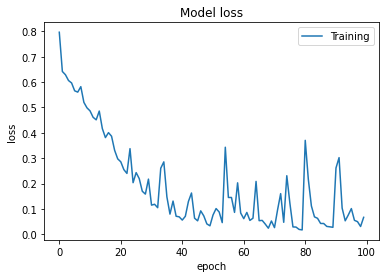

In [37]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training'], loc='upper right')
plt.show()

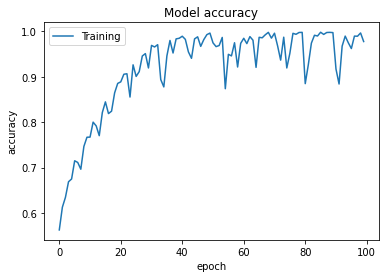

In [38]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Training'], loc='upper left')
plt.show()

<function matplotlib.pyplot.show>

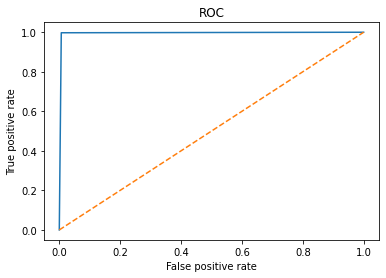

In [39]:
from sklearn.metrics import roc_curve
fpr,tpr ,thresholds =roc_curve(y_test,y_pred)
plt.figure(figsize=(6,4))
plt.title('ROC')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.show